In [1]:
import os
import pandas as pd

from pyannote.core import Segment, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [2]:
def txt2annotation(path_txt, annotation=Annotation()):
    #check if file is txt of csv
    if path_txt.endswith('.txt'):
        with open(path_txt, 'r') as f:
            for line in f:
                if len(line) == 0:
                    continue
                start, end, speaker = line.split()
                speaker = speaker.lower()
                annotation[Segment(float(start), float(end))] = speaker
            return annotation
    elif path_txt.endswith('.csv'):
        diarization = pd.read_csv(path_txt)
        for index, row in diarization.iterrows():
            start = row['start [s]']
            end = row['end [s]']
            speaker = row['speaker']
            annotation[Segment(float(start), float(end))] = speaker
        return annotation

# Primero, una prueba sencilla

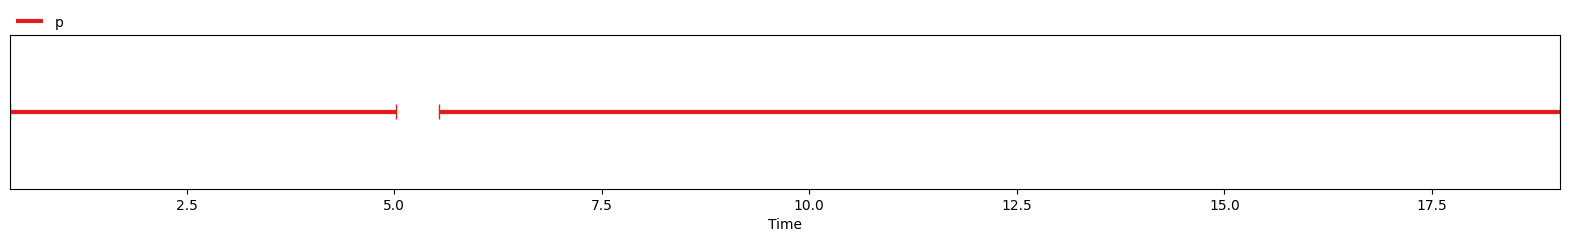

In [3]:
# reference annotation
reference_path = os.path.join('REDLAT', 'reference', 'ASW', 'REDLAT_AF111_CraftIm.txt')
reference = txt2annotation(reference_path, annotation=Annotation(uri='test'))
reference

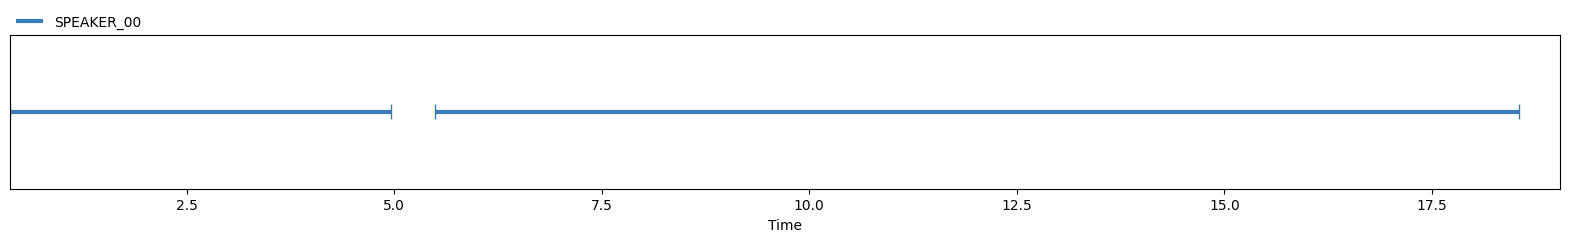

In [4]:
# hypothesis annotation
hypothesis_path = os.path.join('REDLAT', 'hypothesis', 'ASW', 'diarization_min_max', 'REDLAT_AF111_CraftIm_diarization.csv')
hypothesis = txt2annotation(hypothesis_path, annotation=Annotation(uri='test'))
hypothesis

In [5]:
# DER
metric(reference, hypothesis, detailed=True)

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


{'confusion': 0.0,
 'total': 18.151432,
 'missed detection': 0.5459630000000013,
 'correct': 17.605469,
 'false alarm': 0.4085310000000001,
 'diarization error rate': 0.052585052242710185}

In [6]:
# full report and reset metric
report = metric.report(display=True)
metric.reset()

      diarization error rate total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                     %                       %                                 %                   %
item                                                                                                                            
test                    5.26 18.15   17.61   96.99        0.41        2.25             0.55             3.01      0.00      0.00
TOTAL                   5.26 18.15   17.61   96.99        0.41        2.25             0.55             3.01      0.00      0.00


# Ahora obtengamos un DER para todos los pares reference - hypothesis de la base combinada

In [7]:
import warnings
warnings.filterwarnings("ignore")

count = 0
# find all txt files in reference directory
reference_dir = os.path.join('REDLAT', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('reference', 'hypothesis')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    # print('Error in file:', reference_path)
                    # print(reference_path)
                    # log reference_path to file
                    with open('error_log.txt', 'a') as f:
                        f.write(reference_path)
                        f.write('\n')
                    count += 1
                    # print(count)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_report.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', count)

0.37567968365263493
                                 diarization error rate    total  correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                      %                         %                       %                                 %                   %
item                                                                                                                                                           
REDLAT_BN00142_CraftIm.txt                        33.16    24.17    17.28   71.50        1.13        4.66             6.89            28.50      0.00      0.00
REDLAT_AF257_Phonological2.txt                    37.73    40.90    25.47   62.27        0.00        0.00            15.43            37.73      0.00      0.00
REDLAT_MA439_Phonological2.txt                    56.18    16.43     7.20   43.82        0.00        0.00             8.45            51.43      0.78      4.75
REDLAT_CU148_Semanti

In [10]:
# DER report based on PM code

codes = ['AF', 'BE', 'BN','CU', 'LO', 'MA','SL']

for code in codes:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and code in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except Exception as e:
                        print(e)
                        print('Error in file:', reference_path)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results_min_max/DER_report_{code}.csv')
    metric.reset() # reset metric for next iteration

0.33599388084055515
                               diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                    %                       %                       %                                 %                   %
item                                                                                                                                                       
REDLAT_AF257_Phonological2.txt                  37.73   40.90   25.47   62.27        0.00        0.00            15.43            37.73      0.00      0.00
REDLAT_AF178_Phonological.txt                   34.04   27.07   18.45   68.13        0.59        2.17             7.59            28.05      1.03      3.82
REDLAT_AF111_Semantic.txt                       39.13   52.43   34.68   66.14        2.76        5.27             5.32            10.15     12.43     23.70
REDLAT_AF230_Semantic.txt                   

In [11]:
# DER report based on task code

codes = ['Phonological', 'CraftIm', 'Fugu','CraftDe', 'Semantic']

for code in codes:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and code in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        print('Error in file:', reference_path)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results_min_max/DER_report_{code}.csv')
    metric.reset() # reset metric for next iteration

0.5252448859341832
                                 diarization error rate    total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                      %                        %                       %                                 %                   %
item                                                                                                                                                          
REDLAT_AF257_Phonological2.txt                    37.73    40.90   25.47   62.27        0.00        0.00            15.43            37.73      0.00      0.00
REDLAT_MA439_Phonological2.txt                    56.18    16.43    7.20   43.82        0.00        0.00             8.45            51.43      0.78      4.75
REDLAT_CU226_Phonological.txt                     22.47    28.42   24.79   87.23        2.75        9.69             3.09            10.87      0.54      1.91
REDLAT_MA615_Phonological2.

In [ ]:
# DER report ommiting 'CU' code

codes = ['AF', 'BE', 'BN', 'LO', 'MA','SL']
# find all txt files in reference directory
reference_dir = os.path.join('REDLAT', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt') and any(code in file for code in codes):
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('reference', 'hypothesis')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, 'diarization', filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    print('Error in file:', reference_path)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv(f'REDLAT/results/DER_report_no_CU.csv')
metric.reset() # reset metric for next iteration

In [20]:
# now lets exlude the 'Phonological' and 'Semantic' tasks

codes = ['Semantic']

PM = ['AF', 'BE', 'BN', 'LO', 'MA','SL', 'CU']
for site in PM:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and any(code in file for code in codes) and site in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        print('Error in file:', reference_path)


    # cumulative report
    # print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results_min_max/Semantic/{site}_Semantic.csv')
    metric.reset() # reset metric for next iteration

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and

                           diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                %                       %                       %                                 %                   %
item                                                                                                                                                   
REDLAT_AF111_Semantic.txt                   39.13   52.43   34.68   66.14        2.76        5.27             5.32            10.15     12.43     23.70
REDLAT_AF230_Semantic.txt                   35.69   22.69   15.26   67.25        0.67        2.94             7.06            31.12      0.37      1.63
REDLAT_AF202_Semantic2.txt                  30.31   33.11   24.55   74.15        1.48        4.46             5.37            16.21      3.19      9.64
REDLAT_AF162_Semantic2.txt                  32.38   38.64   27.31   70.69        1.19   

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and

                             diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                  %                       %                       %                                 %                   %
item                                                                                                                                                     
REDLAT_BN00115_Semantic.txt                   29.16   41.45   30.17   72.77        0.80        1.94            11.23            27.10      0.05      0.12
REDLAT_BN00112_Semantic.txt                   49.17   32.94   18.36   55.73        1.61        4.90             7.22            21.92      7.36     22.34
REDLAT_BN00145_Semantic.txt                   36.91   27.22   17.91   65.81        0.74        2.72             9.07            33.31      0.24      0.87
REDLAT_BN00049_Semantic2.txt                  30.72   52.38   38.27   73.06 

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and

                           diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                %                       %                       %                                 %                   %
item                                                                                                                                                   
REDLAT_MA412_Semantic.txt                   78.33   24.11   13.61   56.46        8.39       34.79             1.77             7.36      8.73     36.18
REDLAT_MA358_Semantic2.txt                  65.89   16.04    5.71   35.62        0.24        1.51             7.97            49.65      2.36     14.73
REDLAT_MA595_Semantic.txt                   28.53   18.55   13.78   74.29        0.52        2.82             3.64            19.64      1.12      6.06
REDLAT_MA638_Semantic2.txt                  33.22   15.64   10.44   66.78        0.00   

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and

                             diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                  %                       %                       %                                 %                   %
item                                                                                                                                                     
REDLAT_SL00379_Semantic.txt                   58.12   14.58    6.65   45.62        0.55        3.74             7.13            48.91      0.80      5.47
REDLAT_SL00442_Semantic.txt                   21.46   42.59   36.30   85.24        2.85        6.69             6.29            14.76      0.00      0.00
REDLAT_SL00342_Semantic.txt                   27.57   23.18   16.92   73.02        0.14        0.59             6.25            26.98      0.00      0.00
REDLAT_SL00296_Semantic.txt                   31.36   46.30   33.71   72.80 

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and

                           diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                %                       %                       %                                 %                   %
item                                                                                                                                                   
REDLAT_CU148_Semantic.txt                   65.28   30.72   14.59   47.49        3.92       12.77             8.01            26.08      8.12     26.43
REDLAT_CU403_Semantic2.txt                  59.29   22.80   15.69   68.80        6.40       28.09             2.95            12.95      4.16     18.25
REDLAT_CU402_Semantic.txt                   52.91   36.93   21.49   58.18        4.09       11.09            13.45            36.43      1.99      5.39
REDLAT_CU307_Semantic2.txt                  24.13   36.11   30.81   85.34        3.42   

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and